In [1]:
import numpy as np
from matplotlib import pyplot as plt
import csv
from datetime import datetime, timedelta
import nbconvert

In [2]:
fname = "covid-19-data/us-counties.csv"
pop_data_fname = "us-census-data/county_data.csv"

In [3]:
county_pops = {}
csv_reader = csv.DictReader(open(pop_data_fname, 'r', newline='', encoding='ISO-8859-1'))
for entry in csv_reader:
    # print(entry['STNAME'] + " - " + entry['CTYNAME'])
    state_entry = county_pops.get(entry['STNAME'], {})
    county_name = entry["CTYNAME"].replace(" County", "")
    state_entry[county_name] = float(entry["POPESTIMATE2019"])
    county_pops[entry['STNAME']] = state_entry
county_pops["New York"]["New York City"] = 8.399e6
print("LA -> " + str(county_pops["California"]["Los Angeles"]))
print("Catoosa -> " + str(county_pops["Georgia"]["Catoosa"]))
print("Grimes -> " + str(county_pops["Texas"]["Grimes"]))

LA -> 10039107.0
Catoosa -> 67580.0
Grimes -> 28880.0


In [4]:
population_drop_thresh = 30000
csv_reader = csv.DictReader(open(fname))
data = []
for entry in csv_reader:
    if entry['county'].lower() == "unknown":
        continue
    raw_pop = county_pops.get(entry['state'], {}).get(entry['county'], 0.0)
    if True:
        if raw_pop <= 0.0 or raw_pop < population_drop_thresh:
            continue
        entry['population'] = raw_pop
    entry['county'] = entry['state'] + " - " + entry['county']
    data.append(entry)


In [5]:
def entry_to_days(entry):
    """Converts a YYYY-mm-dd date into an integer with 0 being 2020-01-01"""
    d1 = datetime.strptime(entry['date'], "%Y-%m-%d")
    d0 = datetime.strptime("2020-01-01", "%Y-%m-%d")
    return(d1 - d0).days

def date_from_daynum(daynum):
    return datetime.strptime("2020-01-01", "%Y-%m-%d") + timedelta(days=daynum)
    

In [6]:
data[0]

OrderedDict([('date', '2020-01-21'),
             ('county', 'Washington - Snohomish'),
             ('state', 'Washington'),
             ('fips', '53061'),
             ('cases', '1'),
             ('deaths', '0'),
             ('population', 822083.0)])

In [7]:
# Now we extract data for all counties in this state
counties = {}
for d in data:
    l = counties.get(d['county'], [])
    val = float(d["cases"])
    other_val = float(d["deaths"])
    l.append([entry_to_days(d), val, other_val])
    counties[d['county']] = l
for county in counties:
    counties[county] = sorted(counties[county])

In [8]:
[k for k in counties.keys()][0], counties[[k for k in counties.keys()][0]][:3]

('Washington - Snohomish', [[20, 1.0, 0.0], [21, 1.0, 0.0], [22, 1.0, 0.0]])

In [9]:
changes = {}
smoothing = 1
for county in counties:
    ds = [e[2] for e in counties[county]]
    cs = [e[1] for e in counties[county]]
    ts = [e[0] for e in counties[county]]
    d_rates = [ds[t] - ds[t-smoothing] for t in range(smoothing, len(ds))]
    c_rates = [cs[t] - cs[t-smoothing] for t in range(smoothing, len(cs))]
    changes[county] = [[ts[smoothing+i], c_rates[i], d_rates[i]] for i in range(len(d_rates))]

In [10]:
def mat_stacks_for_county(county, window=30):
    lhs = []
    rhs = []
    for e in changes[county]:
        t = e[0]
        d = e[2]
        if d < 0:
            continue
        v = [0 for i in range(window)]
        denom = max(d, 100)
        for e2 in changes[county]:
            idx = t - e2[0]
            if idx >= window or idx < 0:
                continue
            v[idx] = e2[1]/denom
        lhs.append([d/denom])
        rhs.append(v)
    return (np.array(lhs), np.array(rhs))

In [11]:
v,m = mat_stacks_for_county("New York - New York City")

In [12]:
v.shape, m.shape

((208, 1), (208, 30))

In [13]:
c = np.dot(np.linalg.pinv(m), v)

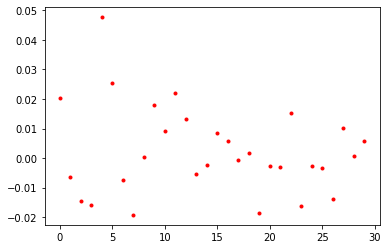

In [14]:
plt.plot([i for i in range(len(c))], c, 'r.')

In [15]:
np.array([])

array([], dtype=float64)

In [16]:
np.hstack([np.eye(3), np.eye(3)]), np.hstack([np.zeros((1,1)), np.zeros((1,1))])

(array([[1., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0., 1.]]),
 array([[0., 0.]]))

In [17]:
def giant_matrix_system(window=60, smooth_weight=500, end_smooth=25000, state=None):
    v_accum = None
    m_accum = None
    for county in counties.keys():
        if state is not None and state not in county.split(" - ")[0]:
            continue
        v,m = mat_stacks_for_county(county, window=window)
        if v_accum is None:
            v_accum = np.copy(v)
            m_accum = np.copy(m)
            continue
        v_accum = np.vstack([v_accum, v])
        m_accum = np.vstack([m_accum, m])
    for idx in range(1, window):
        row = np.zeros((1, window))
        v = np.zeros((1,1))
        row[0, idx] = smooth_weight
        row[0, idx - 1] = -smooth_weight
        v_accum = np.vstack([v_accum, v])
        m_accum = np.vstack([m_accum, row])
    v_accum = np.vstack([v_accum, np.zeros((2,1))])
    last_rows = np.zeros((2, window))
    last_rows[0, 0] = end_smooth
    last_rows[1, -1] = end_smooth
    m_accum = np.vstack([m_accum, last_rows])
    return (v_accum, m_accum)

In [36]:
(v, m) = giant_matrix_system(smooth_weight=1500, end_smooth=50000)

In [37]:
v.shape, m.shape

((269145, 1), (269145, 60))

In [38]:
c = np.dot(np.linalg.pinv(m), v)

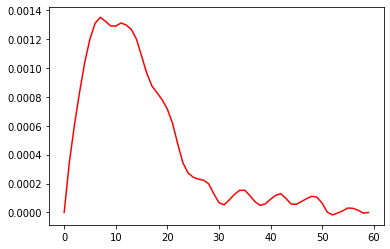

In [39]:
plt.plot([i for i in range(len(c))], c, 'r-')

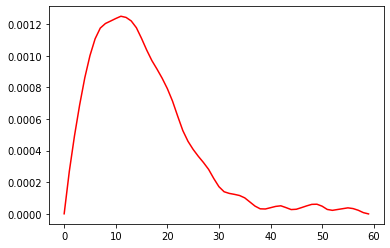

In [40]:
(v, m) = giant_matrix_system(smooth_weight=2500, end_smooth=50000)
c = np.dot(np.linalg.pinv(m), v)
plt.plot([i for i in range(len(c))], c, 'r-')

In [22]:
sum(c)

array([0.02541934])

In [23]:
sum(c[:25]), sum(c[25:])

(array([0.02213447]), array([0.00328487]))

In [24]:
sum([i * c[i] for i in range(len(c))]) / sum(c)

array([14.93812095])

In [25]:
[k for k in counties.keys()][0].split(" - ")[0]

'Washington'

In [26]:
"non" in "banana"

False

In [27]:
def solve_state(state, smooth_weight=2000, end_smooth=40000):
    (v, m) = giant_matrix_system(smooth_weight=smooth_weight, end_smooth=end_smooth, state=state)
    print("made matrix system " + str((v.shape, m.shape)))
    c = np.dot(np.linalg.pinv(m), v)
    print("Solved matrix system")
    plt.plot([i for i in range(len(c))], c, 'r-')
    print("sum(c) is " + str(sum(c)))
    print("expected days is " + str(sum([i * c[i] for i in range(len(c))]) / sum(c)))
    return c

made matrix system ((9644, 1), (9644, 60))
Solved matrix system
sum(c) is [0.01906632]
expected days is [15.87364037]


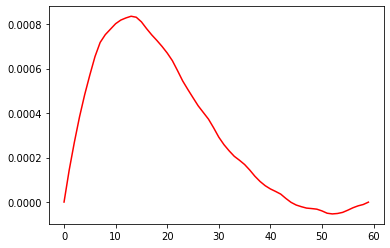

In [28]:
c_cal = solve_state("California")

made matrix system ((18207, 1), (18207, 60))
Solved matrix system
sum(c) is [0.01899781]
expected days is [19.60295373]


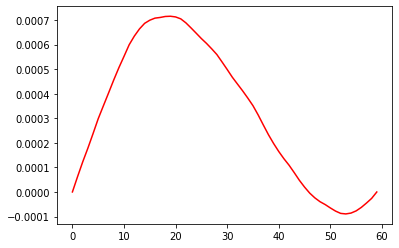

In [29]:
c_tex = solve_state("Texas")

made matrix system ((10672, 1), (10672, 60))
Solved matrix system
sum(c) is [0.04366018]
expected days is [12.61920059]


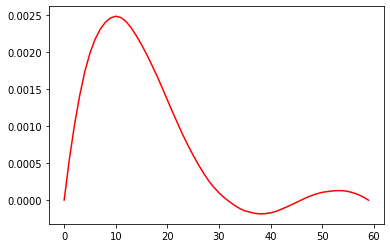

In [30]:
c_ny = solve_state("New York")

made matrix system ((9723, 1), (9723, 60))
Solved matrix system
sum(c) is [0.01710129]
expected days is [26.62699233]


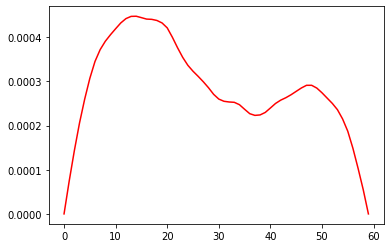

In [31]:
c_fl = solve_state("Florida")

made matrix system ((2618, 1), (2618, 60))
Solved matrix system
sum(c) is [0.0224028]
expected days is [22.45805656]


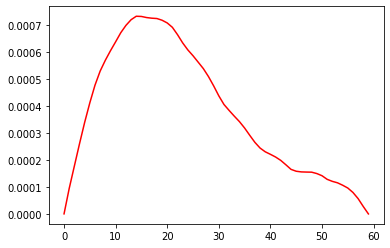

In [32]:
c_az = solve_state("Arizona")

made matrix system ((2765, 1), (2765, 60))
Solved matrix system
sum(c) is [0.00677689]
expected days is [28.72286402]


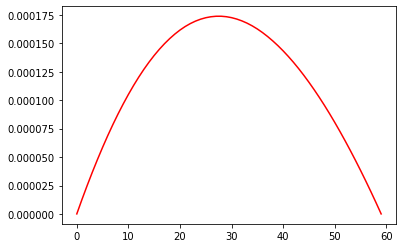

In [33]:
c_nm = solve_state("New Mexico")

made matrix system ((2765, 1), (2765, 60))
Solved matrix system
sum(c) is [0.0265055]
expected days is [26.9141288]


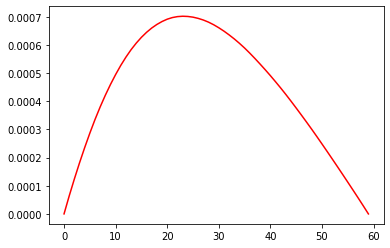

In [34]:
c_nm = solve_state("New Mexico", smooth_weight=500, end_smooth=10000)

made matrix system ((2765, 1), (2765, 60))
Solved matrix system
sum(c) is [0.03261408]
expected days is [17.18762211]


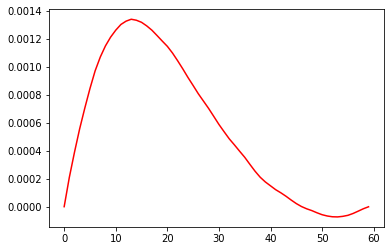

In [35]:
c_nm = solve_state("New Mexico", smooth_weight=100, end_smooth=2000)